In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict
from tqdm import tqdm
import networkx as nx
from matplotlib_venn import venn2, venn3
from neteval import gene_mapper as gm
from neteval import query_ensembl as qe
from neteval import query_hgnc as qh
import obonet as obo
import random as rn
import glob
import re

In [2]:
datadir='/cellar/users/snwright/Data/RareCommon/inputs/testing/'
resdir= '/cellar/users/snwright/Data/RareCommon/outputs/netcoloc/testing/'
outdir='/cellar/users/snwright/Data/Transfer/RVC/'
figdir='/cellar/users/snwright/Data/Transfer/RVC/figures/RAVAR_GWASCat/'

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25

# Holiday runs

In [4]:
def get_file_prefix(datadir, group_trait, pref='qnetcoloc'):
    return os.path.join(datadir, '_'.join([pref, group_trait, group_trait]))

def get_z_file_prefix(datadir, group_trait):
    return os.path.join(datadir, '_'.join([group, trait, 'z']))

def extract_params(filepath):
    suffix_parts = filepath.split('__')[-1].split('_')
    if len(suffix_parts) == 3:
        q = True
        transform = suffix_parts[1]
        norm = suffix_parts[2].split('.txt')[0]
    elif len(suffix_parts) == 1:
        q = False
        transfom = suffix_parts[0].split('.txt')[0]
        norm = None
    return q, transfrom, norm

In [5]:
def get_results(group, trait_list, outdir, q=True):
    with open(trait_list[group], 'r') as f:
        traits = [x.strip() for x in f.readlines()]
    results = []
    for trait in tqdm(traits):
        if q:
            trait_files = glob.glob(get_file_prefix(outdir, trait)+'*')
        else:
            trait_files = glob.glob(get_file_prefix(outdir, trait, pref='netcoloc')+'*')
        for file in trait_files:
            trait_df = pd.read_csv(file, sep='\t', header=None)
            trait_df.columns = ['TraitR', 'TraitC', 'Network','Transform', 'Norm', 'Mean_NPS', 'Null_mean_NPS', 'P_mean_NPS', 'Size', 'Null_Size', 'P_size' ]
            trait_df['EFO'] = next((match.group() for match in re.finditer(r'EFO_\d+', file)), None)
            trait_df['Study'] = next((match.group() for match in re.finditer(r'GCST\d+', file)), None)
            results.append(trait_df)
    results_df = pd.concat(results)
    results_df = results_df.assign(q=q)
    results_df['Group'] = group
    results_df['TraitR'] = results_df['TraitR'].apply(lambda x: x.split(group+'_')[-1])
    results_df['TraitC'] = results_df['TraitC'].apply(lambda x: x.split(group+'_')[-1])
    
    return results_df

## Load data
### NearestGene

In [6]:
ngin = '/cellar/users/snwright/Data/RareCommon/inputs/testing'
ngout = '/cellar/users/snwright/Data/RareCommon/outputs/netcoloc/testing'

In [7]:
ng_groups = {'ng':'nearestGene', 'ngth':'nearestGeneTH8'}
ng_traitlists = {ng_groups[x]:os.path.join(ngin, ng_groups[x]+'.traitlist') for x in ng_groups}

In [8]:
ngAll = get_results('nearestGene', ng_traitlists, ngout, q=False)
ngth8 = get_results('nearestGeneTH8', ng_traitlists, ngout, q=False)

100%|██████████| 31/31 [00:00<00:00, 230.99it/s]


In [9]:
qngAll = get_results('nearestGene', ng_traitlists, ngout)
qngth8 = get_results('nearestGeneTH8', ng_traitlists, ngout)

100%|██████████| 31/31 [00:01<00:00, 28.54it/s]


In [71]:
ng_df = pd.concat([ngAll, ngth8, qngAll, qngth8])
ng_df = ng_df.assign(Threshold=ng_df.Group.map({'nearestGeneTH8':'High', 'nearestGene': 'Low'}))
ng_df['Method'] = 'NG'

### MAGMA

In [74]:
magmain = '/cellar/users/snwright/Data/RareCommon/inputs/magma'
magmaout = '/cellar/users/snwright/Data/RareCommon/outputs/netcoloc/magma'

In [75]:
magma_groups = {'magma256':'magma_th256', 'magma103': 'magma_th103', 'magma':'magma_all'}
magma_traitlist = {magma_groups[x]:os.path.join(magmain, magma_groups[x]+'.traitlist') for x in magma_groups}

In [76]:
mg256 = get_results('magma_th256', magma_traitlist, magmaout, q=False)
mg103 = get_results('magma_th103', magma_traitlist, magmaout, q=False)

100%|██████████| 80/80 [00:00<00:00, 132.49it/s]


In [77]:
qmg256 = get_results('magma_th256', magma_traitlist, magmaout)
qmg103 = get_results('magma_th103', magma_traitlist, magmaout)
qmgAll = get_results('magma_all', magma_traitlist, magmaout)

100%|██████████| 90/90 [00:01<00:00, 69.75it/s]


In [78]:
magma_df = pd.concat([qmg256, qmg103, qmgAll, mg256, mg103])
magma_df = magma_df.assign(Threshold=magma_df.Group.map({'magma_th256':'High', 'magma_th103': 'Low', 'magma_all':'All'}))
magma_df['Method'] = 'MAGMA'
magma_df = magma_df[magma_df.Norm != 'zscore']

In [79]:
magma_df.Norm.unique()

array(['minmax', 'log', 'max', nan, 'sum'], dtype=object)

### Combine all results

In [80]:
all_results = pd.concat([magma_df, ng_df])

In [81]:
all_results['Norm'] = all_results.apply(lambda x: 'Binary' if not x.q else x.Norm, axis=1 )
all_results.loc[all_results['Norm'].isna(), 'Norm'] = 'Base'

In [82]:
all_results['EFOStudy'] = all_results['EFO'] + ':' + all_results['Study']

In [83]:
all_results['logPNPS'] = all_results.P_mean_NPS.apply(lambda x: -1 * np.log10(x + 1e-250))
all_results['logPSize'] = all_results.P_size.apply(lambda x: -1 * np.log10(x + 1e-250))

In [84]:
all_results.to_csv('/cellar/users/snwright/Data/RareCommon/outputs/netcoloc/ng_magma_testing_results_within.tsv', 
                  sep='\t', index=False)

## Comparisons

### Comparison Methods

### NG vs MAGMA

In [55]:
comp1 = all_results[all_results.Group.isin(['magma_th103', 'nearestGene'])].dropna()
comp2 = all_results[all_results.Group.isin(['magma_th256', 'nearestGeneTH8'])].dropna()

In [56]:
norm_methods = [x for x in all_results.Norm.unique() if x != 'zscore']
len(norm_methods)

6

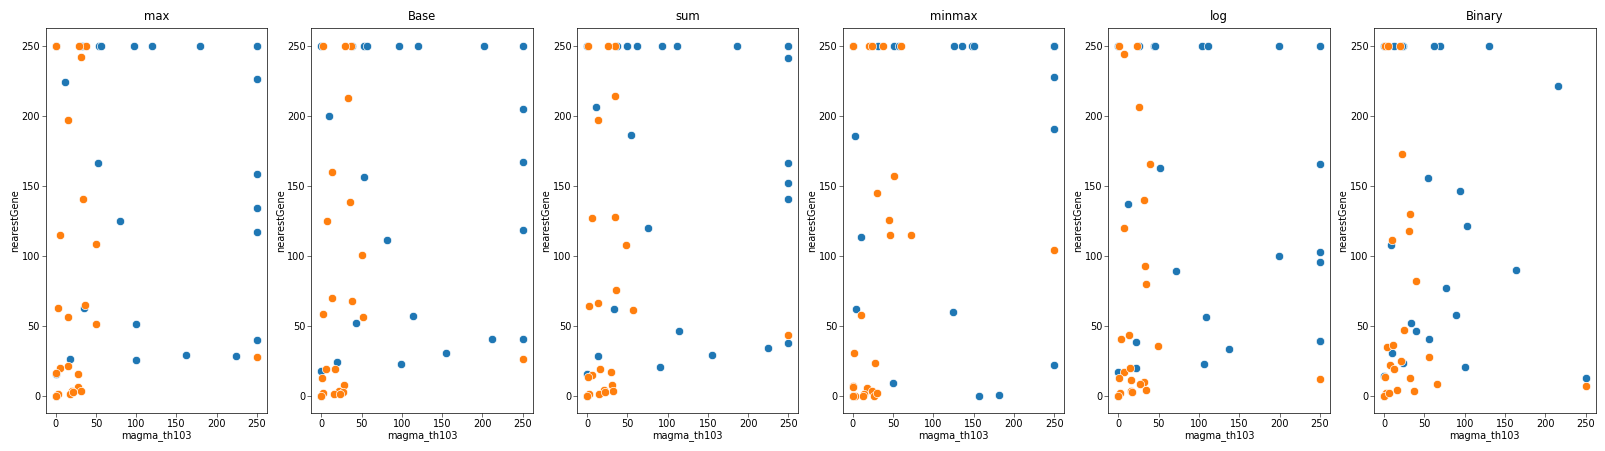

In [57]:
_, axs = plt.subplots(nrows=1, ncols=6, figsize=(20, 5))

for i, norm_method in enumerate(norm_methods):
    plot_data = comp1[comp1.Norm==norm_method].pivot_table(index='EFOStudy', columns='Group', values='logPNPS').dropna()
    sns.scatterplot(plot_data, x='magma_th103', y='nearestGene', ax=axs[i])
    plot_data = comp1[comp1.Norm==norm_method].pivot_table(index='EFOStudy', columns='Group', values='logPSize').dropna()
    sns.scatterplot(plot_data, x='magma_th103', y='nearestGene', ax=axs[i])
    axs[i].set_title(norm_method)

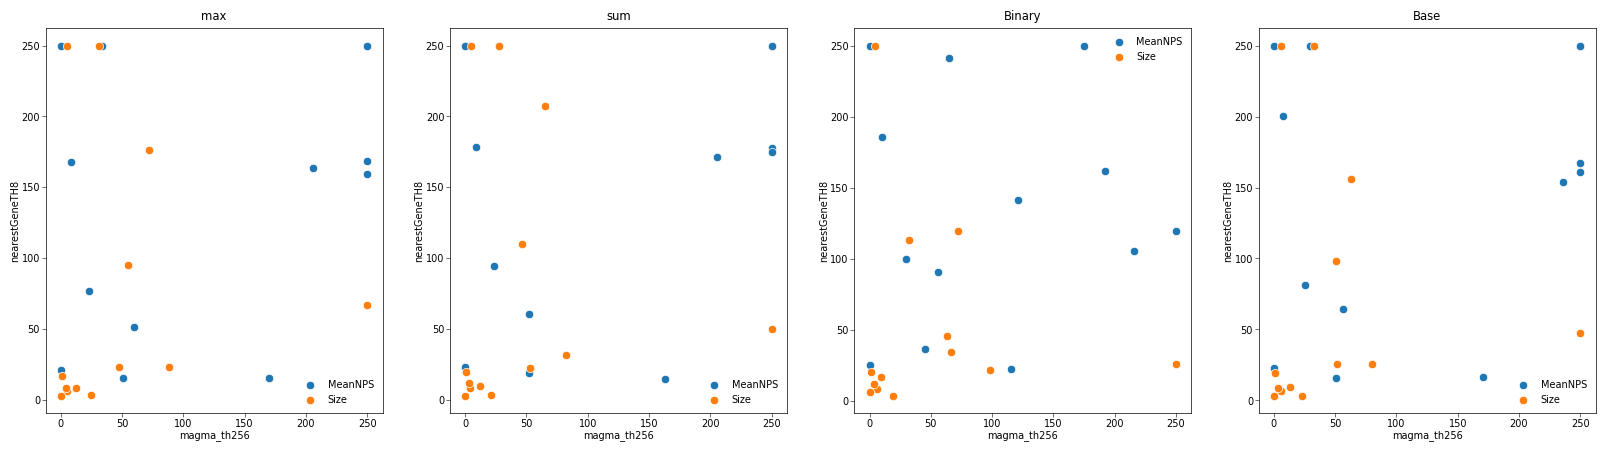

In [58]:
_, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

for i, norm_method in enumerate(['max', 'sum', 'Binary', 'Base']):
    plot_data = comp2[comp2.Norm==norm_method].pivot_table(index='EFOStudy', columns='Group', values='logPNPS').dropna()
    sns.scatterplot(plot_data, x='magma_th256', y='nearestGeneTH8', ax=axs[i], label='MeanNPS')
    plot_data = comp2[comp2.Norm==norm_method].pivot_table(index='EFOStudy', columns='Group', values='logPSize').dropna()
    sns.scatterplot(plot_data, x='magma_th256', y='nearestGeneTH8', ax=axs[i], label='Size')
    axs[i].set_title(norm_method)

In [38]:
norm_method

'minmax'

### Normalization Method

In [59]:
norm1 = all_results[all_results.Group.isin(['nearestGene', 'nearestGeneTH8'])].dropna()
norm2 = all_results[all_results.Group.isin(['magma_th256', 'magma_th103', 'magma_all'])].dropna()

In [60]:
def compare_norm_methods(data, group):
    nps_data = data[data.Group==group].pivot_table(index='EFOStudy', columns='Norm', values='logPNPS')
    size_data = data[data.Group==group].pivot_table(index='EFOStudy', columns='Norm', values='logPSize')
    n_norm = nps_data.shape[1]
    methods = nps_data.columns
    n_plots = round( (n_norm)*(n_norm - 1)/2)
    _, all_axs = plt.subplots(nrows=round((n_plots+1)/3), ncols=3, figsize=(10, 3*round((n_plots+1)/3)))
    axs = [x for xs in all_axs for x in xs]
    ax_idx = 0
    for i, norm_method1 in enumerate(methods):
        for j, norm_method2 in enumerate(methods):
            if i > j:
                sns.scatterplot(nps_data, x=norm_method1, y=norm_method2, ax=axs[ax_idx], label='MeanNPS', s=20)
                sns.scatterplot(size_data, x=norm_method1, y=norm_method2, ax=axs[ax_idx], label='Size', s=20)
                sns.lineplot(x=[0, 250], y=[0,250], ax=axs[ax_idx], color='black', linewidth=0.2)
                ax_idx+=1

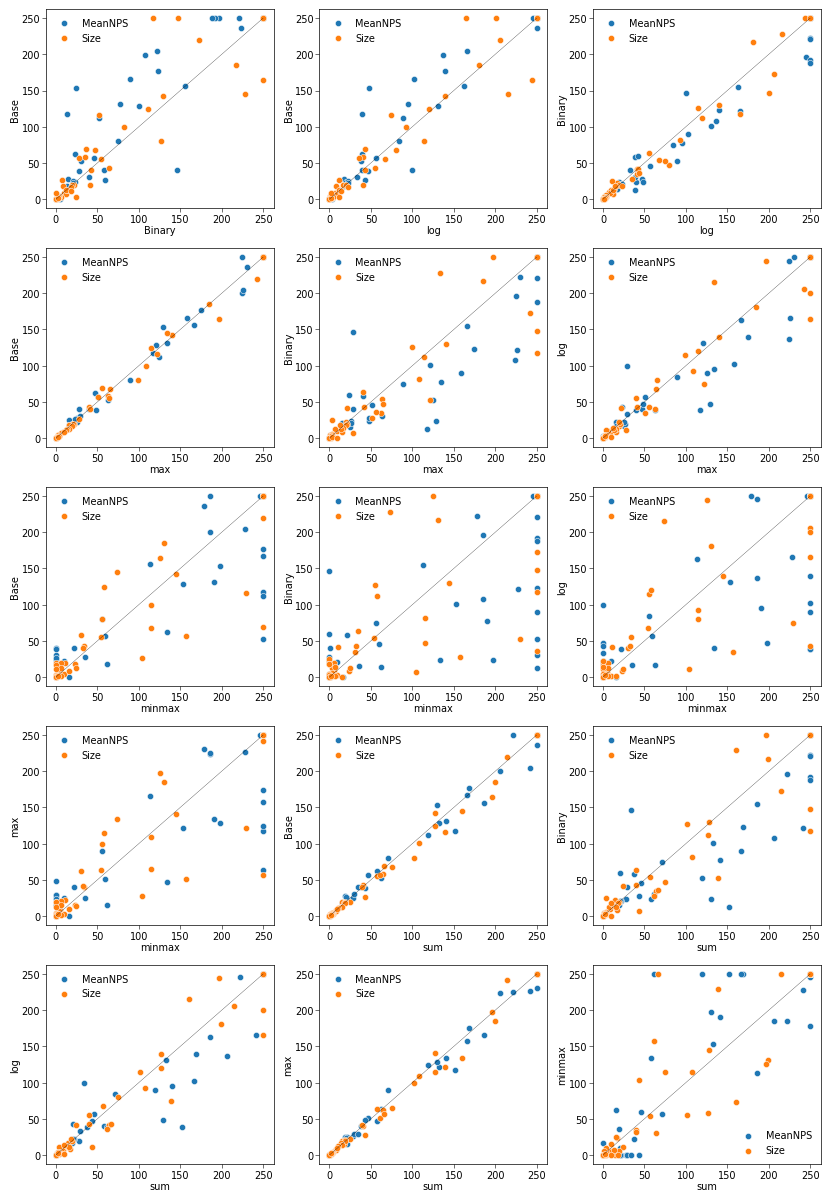

In [43]:
compare_norm_methods(all_results, 'nearestGene')

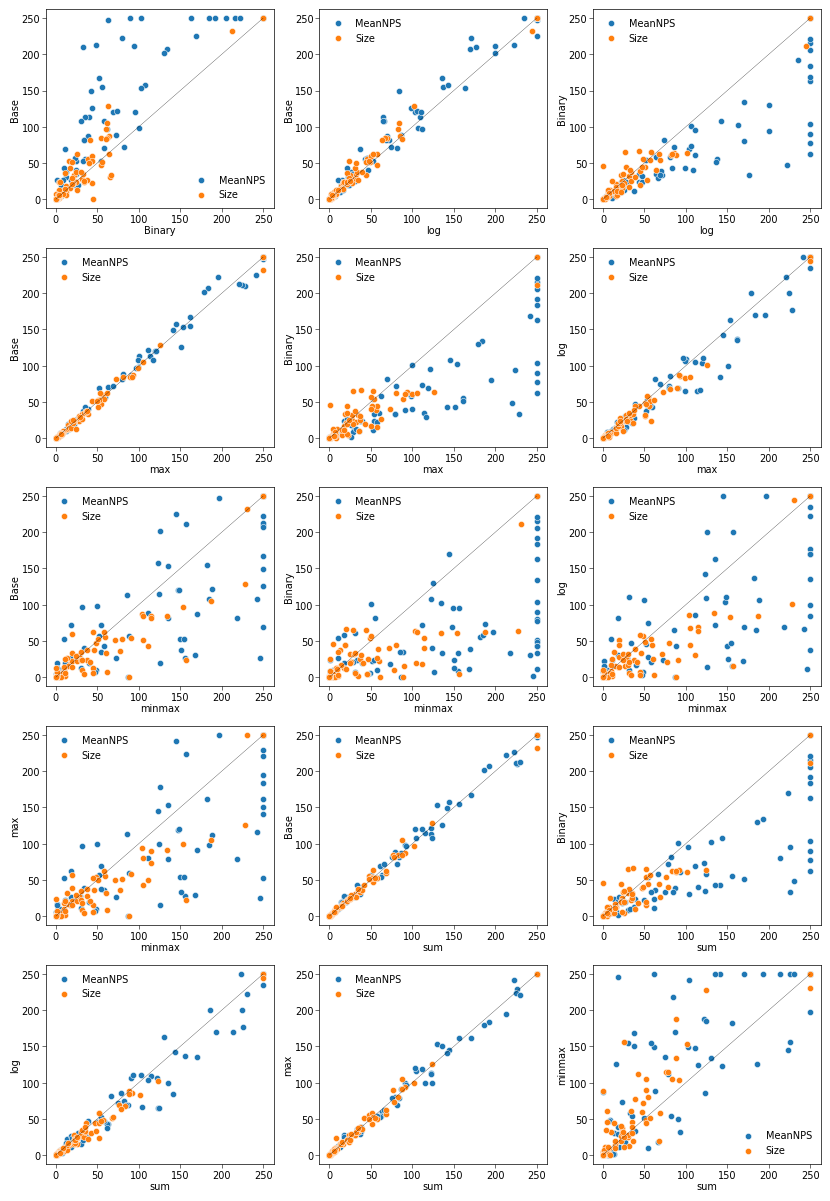

In [44]:
compare_norm_methods(all_results, 'magma_th103')

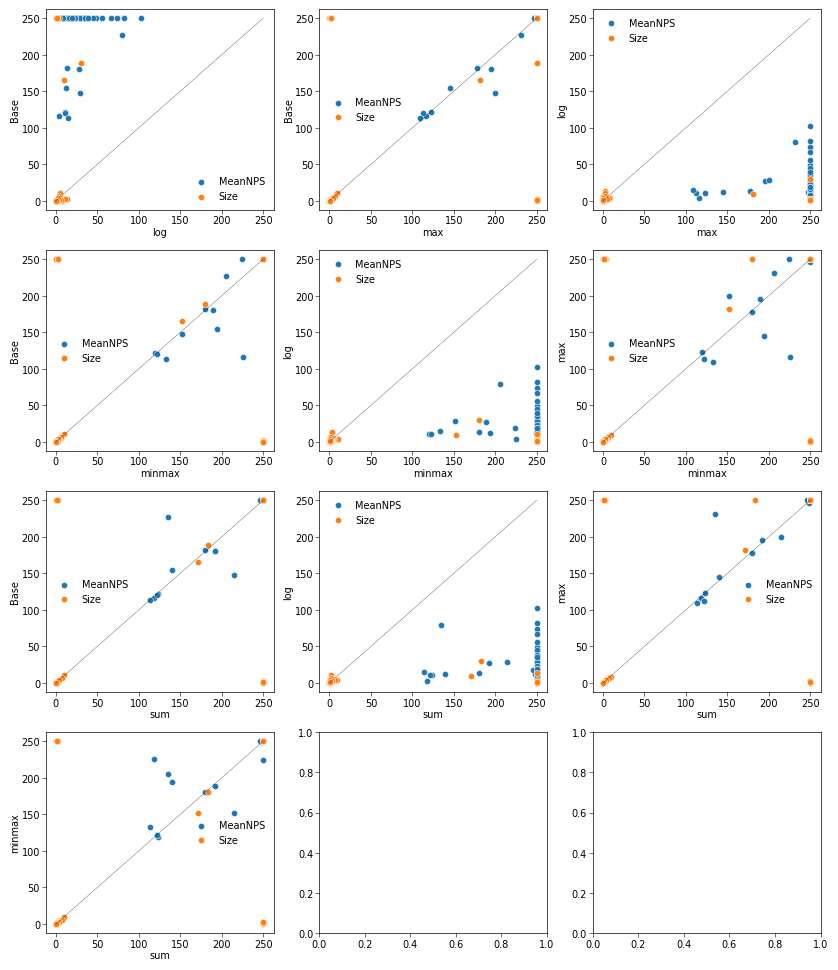

In [61]:
compare_norm_methods(all_results, 'magma_all')

In [64]:
all_results[all_results.Group=='magma_all'].sort_values('logPSize', ascending=False)

,TraitR,TraitC,Network,Transform,Norm,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,P_size,EFO,Study,q,Group,Threshold,Method,EFOStudy,logPNPS,logPSize
0,GCST90024169_EFO_0010362,GCST90024169_EFO_0010362,pcnet2_0,neglog10,minmax,4.532062,3.513949,1.114000e-290,128,0.000,0.0,EFO_0010362,GCST90024169,True,magma_all,All,MAGMA,EFO_0010362:GCST90024169,250.000000,250.0
0,GCST90060151_EFO_0010370,GCST90060151_EFO_0010370,pcnet2_0,neglog10,Base,2.871686,2.325270,0.000000e+00,170,0.000,0.0,EFO_0010370,GCST90060151,True,magma_all,All,MAGMA,EFO_0010370:GCST90060151,250.000000,250.0
0,GCST90018728_EFO_0004741,GCST90018728_EFO_0004741,pcnet2_0,neglog10,Base,5.054482,4.098475,8.127000e-148,144,0.000,0.0,EFO_0004741,GCST90018728,True,magma_all,All,MAGMA,EFO_0004741:GCST90018728,147.090070,250.0
0,GCST90018771_EFO_0009934,GCST90018771_EFO_0009934,pcnet2_0,neglog10,minmax,3.954698,3.126430,1.310000e-290,182,0.000,0.0,EFO_0009934,GCST90018771,True,magma_all,All,MAGMA,EFO_0009934:GCST90018771,250.000000,250.0
0,GCST90094961_EFO_0008036,GCST90094961_EFO_0008036,pcnet2_0,neglog10,max,4.588365,3.626533,1.899000e-256,167,0.000,0.0,EFO_0008036,GCST90094961,True,magma_all,All,MAGMA,EFO_0008036:GCST90094961,249.999999,250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,GCST90025965_EFO_0004531,GCST90025965_EFO_0004531,pcnet2_0,neglog10,Base,0.195004,0.001518,5.254000e-117,57,224.571,1.0,EFO_0004531,GCST90025965,True,magma_all,All,MAGMA,EFO_0004531:GCST90025965,116.279510,-0.0
0,GCST008971_EFO_0004531,GCST008971_EFO_0004531,pcnet2_0,neglog10,max,0.247980,0.001045,8.863000e-196,111,183.289,1.0,EFO_0004531,GCST008971,True,magma_all,All,MAGMA,EFO_0004531:GCST008971,195.052419,-0.0
0,GCST008971_EFO_0004531,GCST008971_EFO_0004531,pcnet2_0,neglog10,log,0.090279,0.000807,2.849000e-28,242,317.237,1.0,EFO_0004531,GCST008971,True,magma_all,All,MAGMA,EFO_0004531:GCST008971,27.545308,-0.0
0,GCST008971_EFO_0004531,GCST008971_EFO_0004531,pcnet2_0,neglog10,sum,0.248828,0.001232,1.053000e-192,112,181.589,1.0,EFO_0004531,GCST008971,True,magma_all,All,MAGMA,EFO_0004531:GCST008971,191.977572,-0.0


(array([285.,  31.,   6.,   5.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.        ,  2.99446217,  5.98892433,  8.9833865 , 11.97784867,
        14.97231083, 17.966773  , 20.96123517, 23.95569733, 26.9501595 ,
        29.94462167]),
 <BarContainer object of 10 artists>)

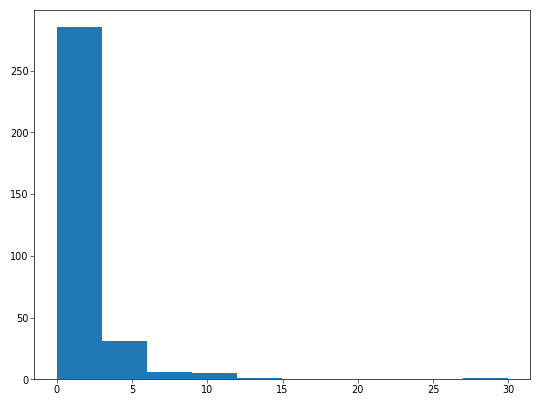

In [65]:
p = all_results[all_results.Group=='magma_all'].logPSize
plt.hist(p[p<50])

#### Additional normalization methods for MAGMA

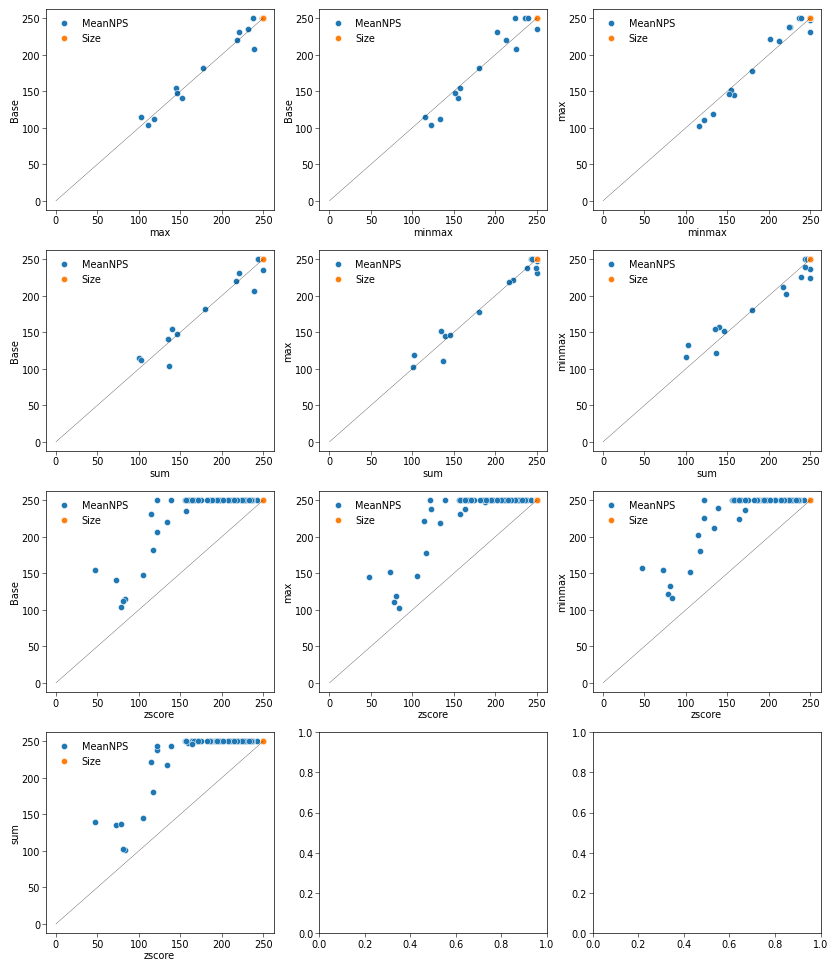

In [255]:
compare_norm_methods(all_results, 'magma_all')

## Thresholds vs no Thresholds

In [275]:
comp1 = all_results[all_results.Group.isin(['nearestGeneTH8', 'nearestGene'])].dropna()
comp2 = all_results[all_results.Group.isin(['magma_th256', 'magma_th103', 'magma_all'])].dropna()

In [280]:
comp2.Threshold.unique()

array(['High', 'Low', 'All'], dtype=object)

#### NG

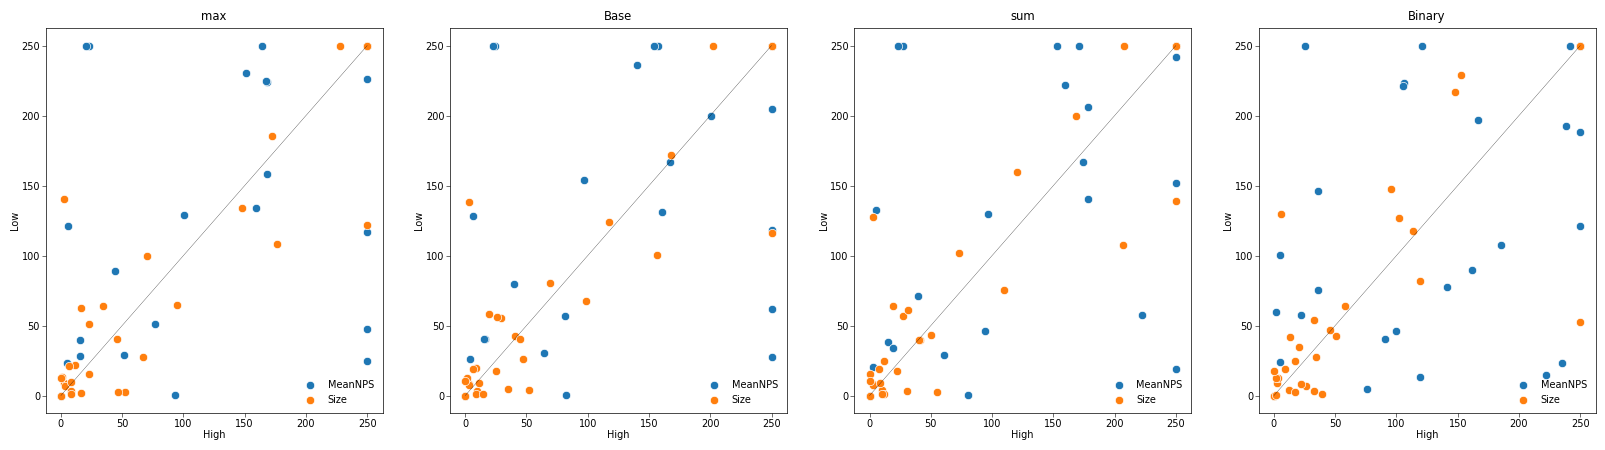

In [276]:
_, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

for i, norm_method in enumerate(norm_traits):
    plot_data = comp1[comp1.Norm==norm_method].pivot_table(index='EFOStudy', columns='Threshold', values='logPNPS').dropna()
    sns.scatterplot(plot_data, x='High', y='Low', ax=axs[i], label='MeanNPS')
    plot_data = comp1[comp1.Norm==norm_method].pivot_table(index='EFOStudy', columns='Threshold', values='logPSize').dropna()
    sns.scatterplot(plot_data, x='High', y='Low', ax=axs[i], label='Size')
    sns.lineplot(x=[0, 250], y=[0,250], ax=axs[i], color='black', linewidth=0.2)
    axs[i].set_title(norm_method)

#### MAGMA

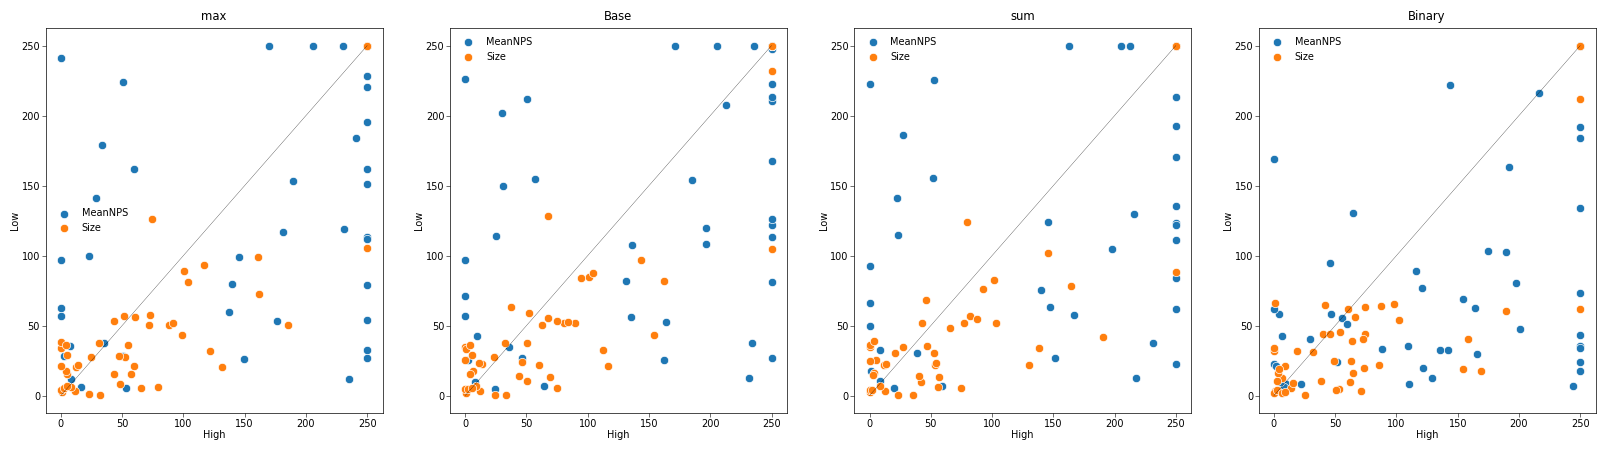

In [277]:
_, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

for i, norm_method in enumerate(norm_traits):
    plot_data = comp2[comp2.Norm==norm_method].pivot_table(index='EFOStudy', columns='Threshold', values='logPNPS').dropna()
    sns.scatterplot(plot_data, x='High', y='Low', ax=axs[i], label='MeanNPS')
    plot_data = comp2[comp2.Norm==norm_method].pivot_table(index='EFOStudy', columns='Threshold', values='logPSize').dropna()
    sns.scatterplot(plot_data, x='High', y='Low', ax=axs[i], label='Size')
    sns.lineplot(x=[0, 250], y=[0,250], ax=axs[i], color='black', linewidth=0.2)
    axs[i].set_title(norm_method)

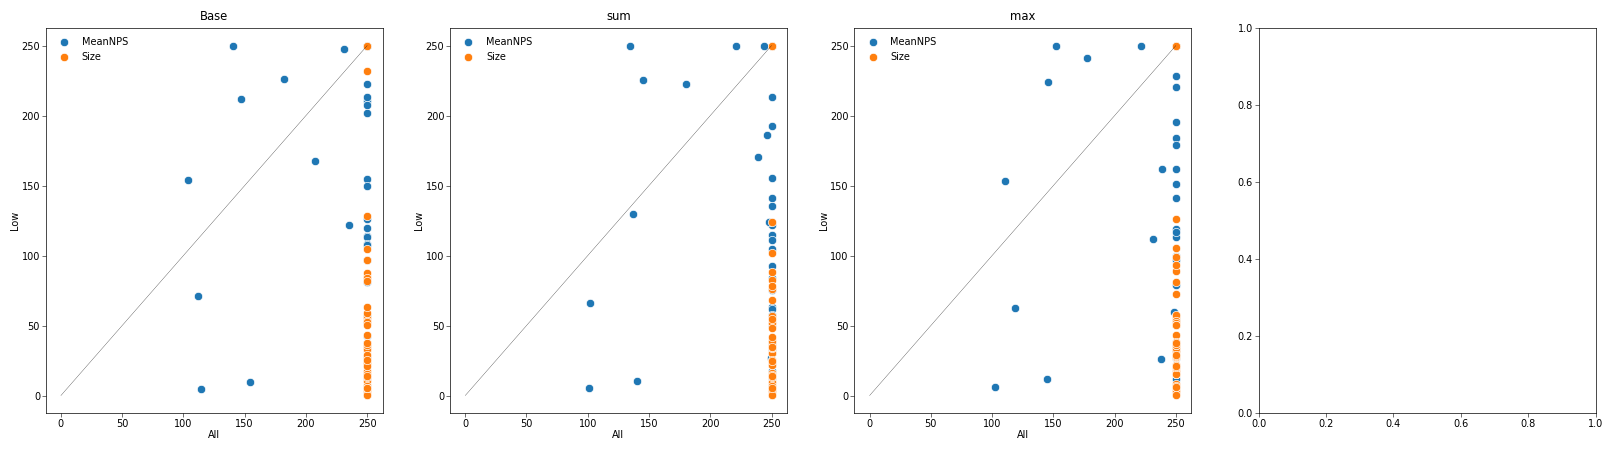

In [281]:
_, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

for i, norm_method in enumerate(['Base', 'sum', 'max']):
    plot_data = comp2[comp2.Norm==norm_method].pivot_table(index='EFOStudy', columns='Threshold', values='logPNPS').dropna()
    sns.scatterplot(plot_data, x='All', y='Low', ax=axs[i], label='MeanNPS')
    plot_data = comp2[comp2.Norm==norm_method].pivot_table(index='EFOStudy', columns='Threshold', values='logPSize').dropna()
    sns.scatterplot(plot_data, x='All', y='Low', ax=axs[i], label='Size')
    sns.lineplot(x=[0, 250], y=[0,250], ax=axs[i], color='black', linewidth=0.2)
    axs[i].set_title(norm_method)

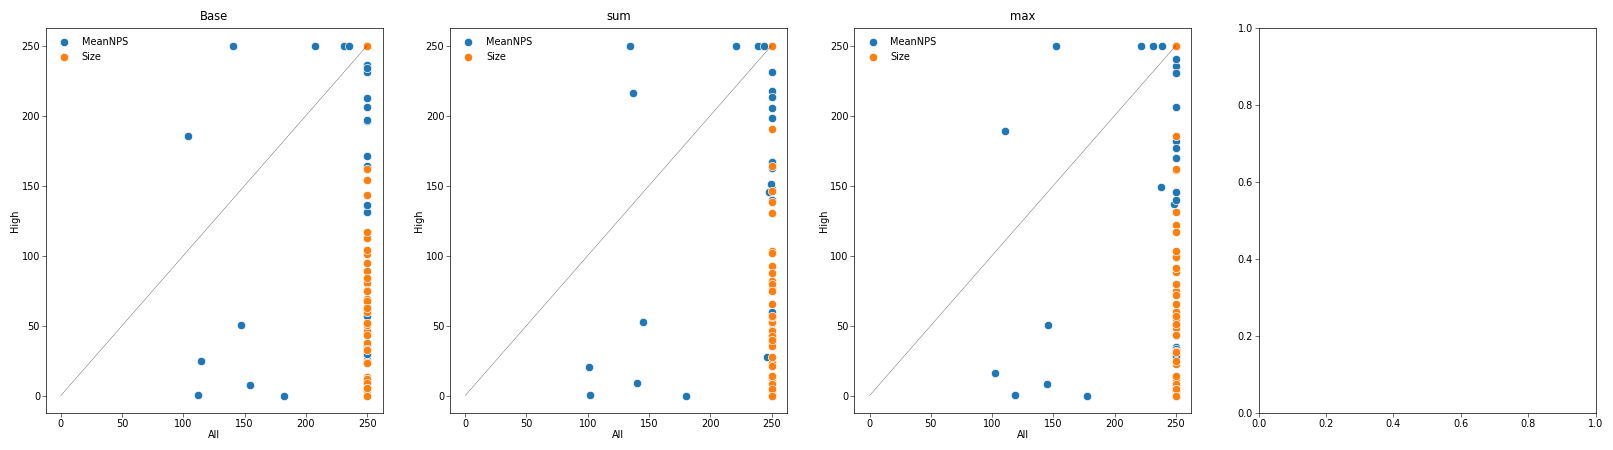

In [282]:
_, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

for i, norm_method in enumerate(['Base', 'sum', 'max']):
    plot_data = comp2[comp2.Norm==norm_method].pivot_table(index='EFOStudy', columns='Threshold', values='logPNPS').dropna()
    sns.scatterplot(plot_data, x='All', y='High', ax=axs[i], label='MeanNPS')
    plot_data = comp2[comp2.Norm==norm_method].pivot_table(index='EFOStudy', columns='Threshold', values='logPSize').dropna()
    sns.scatterplot(plot_data, x='All', y='High', ax=axs[i], label='Size')
    sns.lineplot(x=[0, 250], y=[0,250], ax=axs[i], color='black', linewidth=0.2)
    axs[i].set_title(norm_method)

## Trait Reproducibility

In [287]:
trait_counts = all_results.drop_duplicates(subset=['Study', 'EFO']).loc[:,  ('Study', 'EFO')].EFO.value_counts()
multi_traits = trait_counts[trait_counts > 1].index.tolist()

In [301]:
len(multi_traits)

24

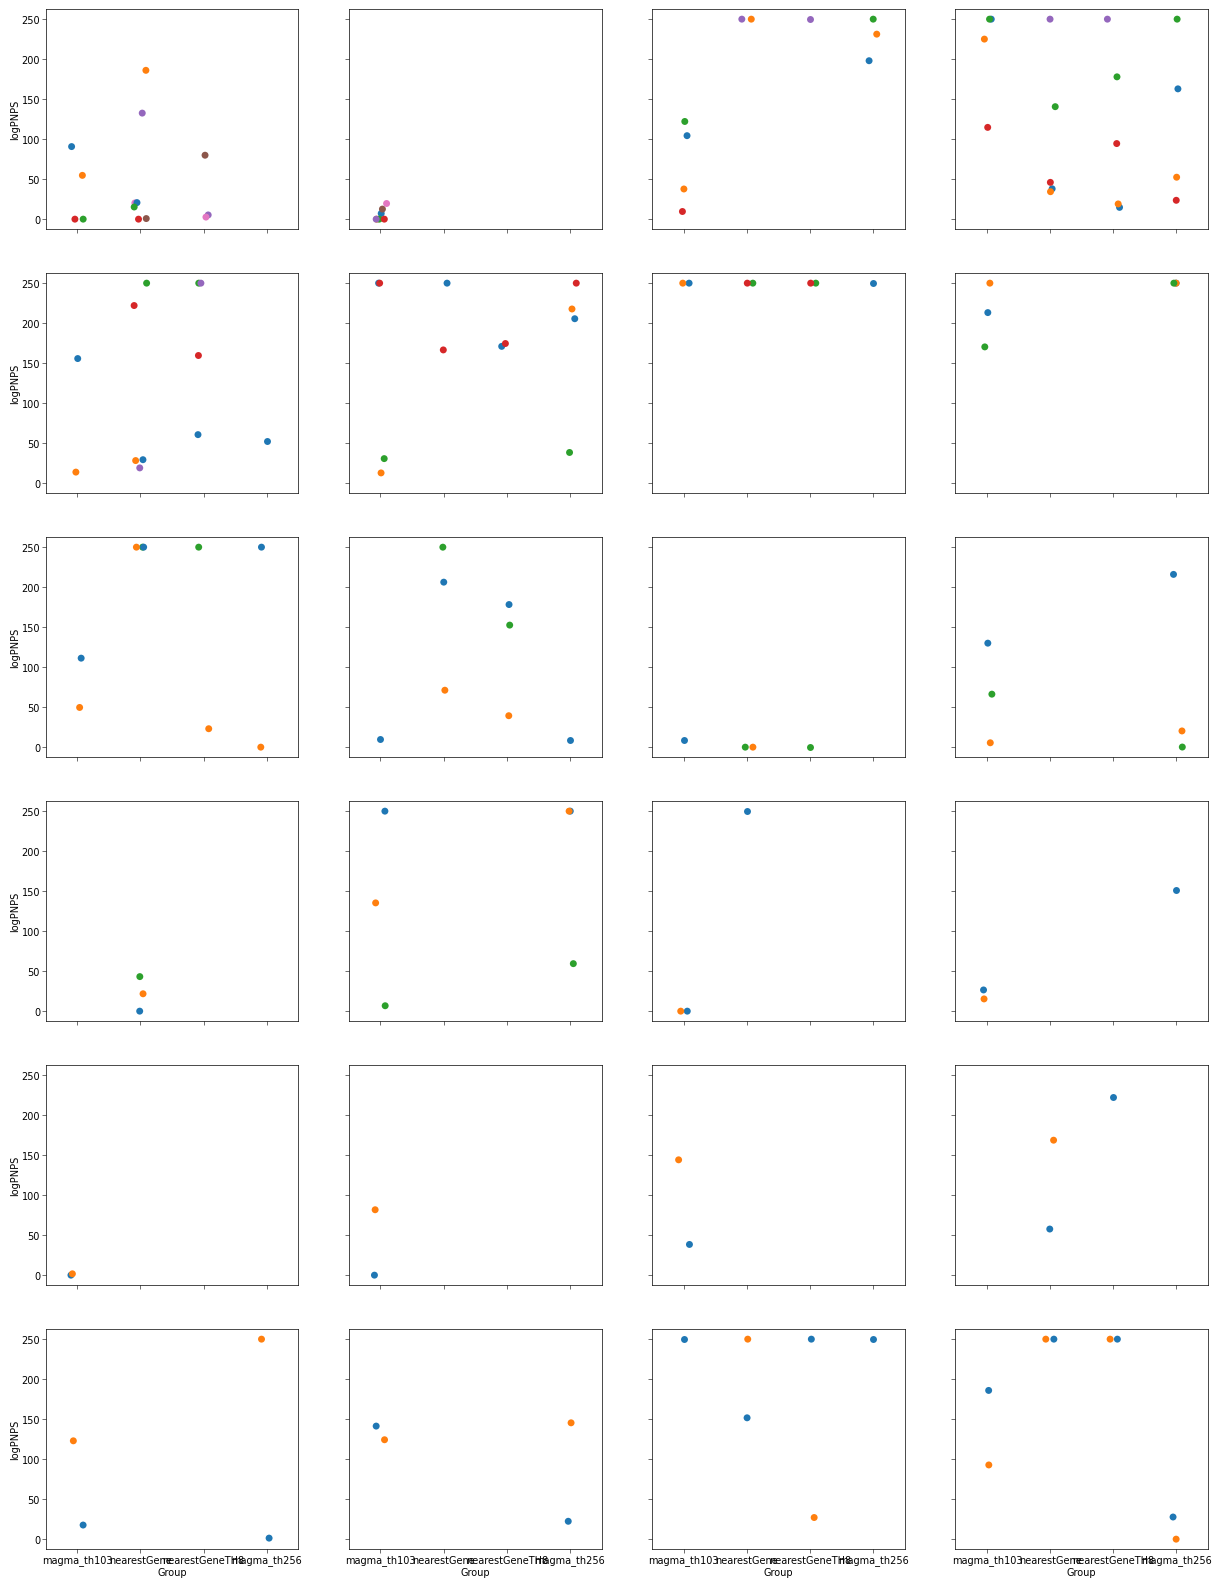

In [307]:
_, all_axs = plt.subplots(nrows=6, ncols=4, figsize=(15, 20), sharex=True, sharey=True)
axs = [x for xs in all_axs for x in xs]
for i, trait in enumerate(multi_traits):
    sns.stripplot(all_results[(all_results.Norm=='sum') &(all_results.EFO==multi_traits[i]) & (all_results.Group != 'magma_all')].reset_index(), 
                    x='Group', y='logPNPS', hue='Study', ax=axs[i], legend=False)

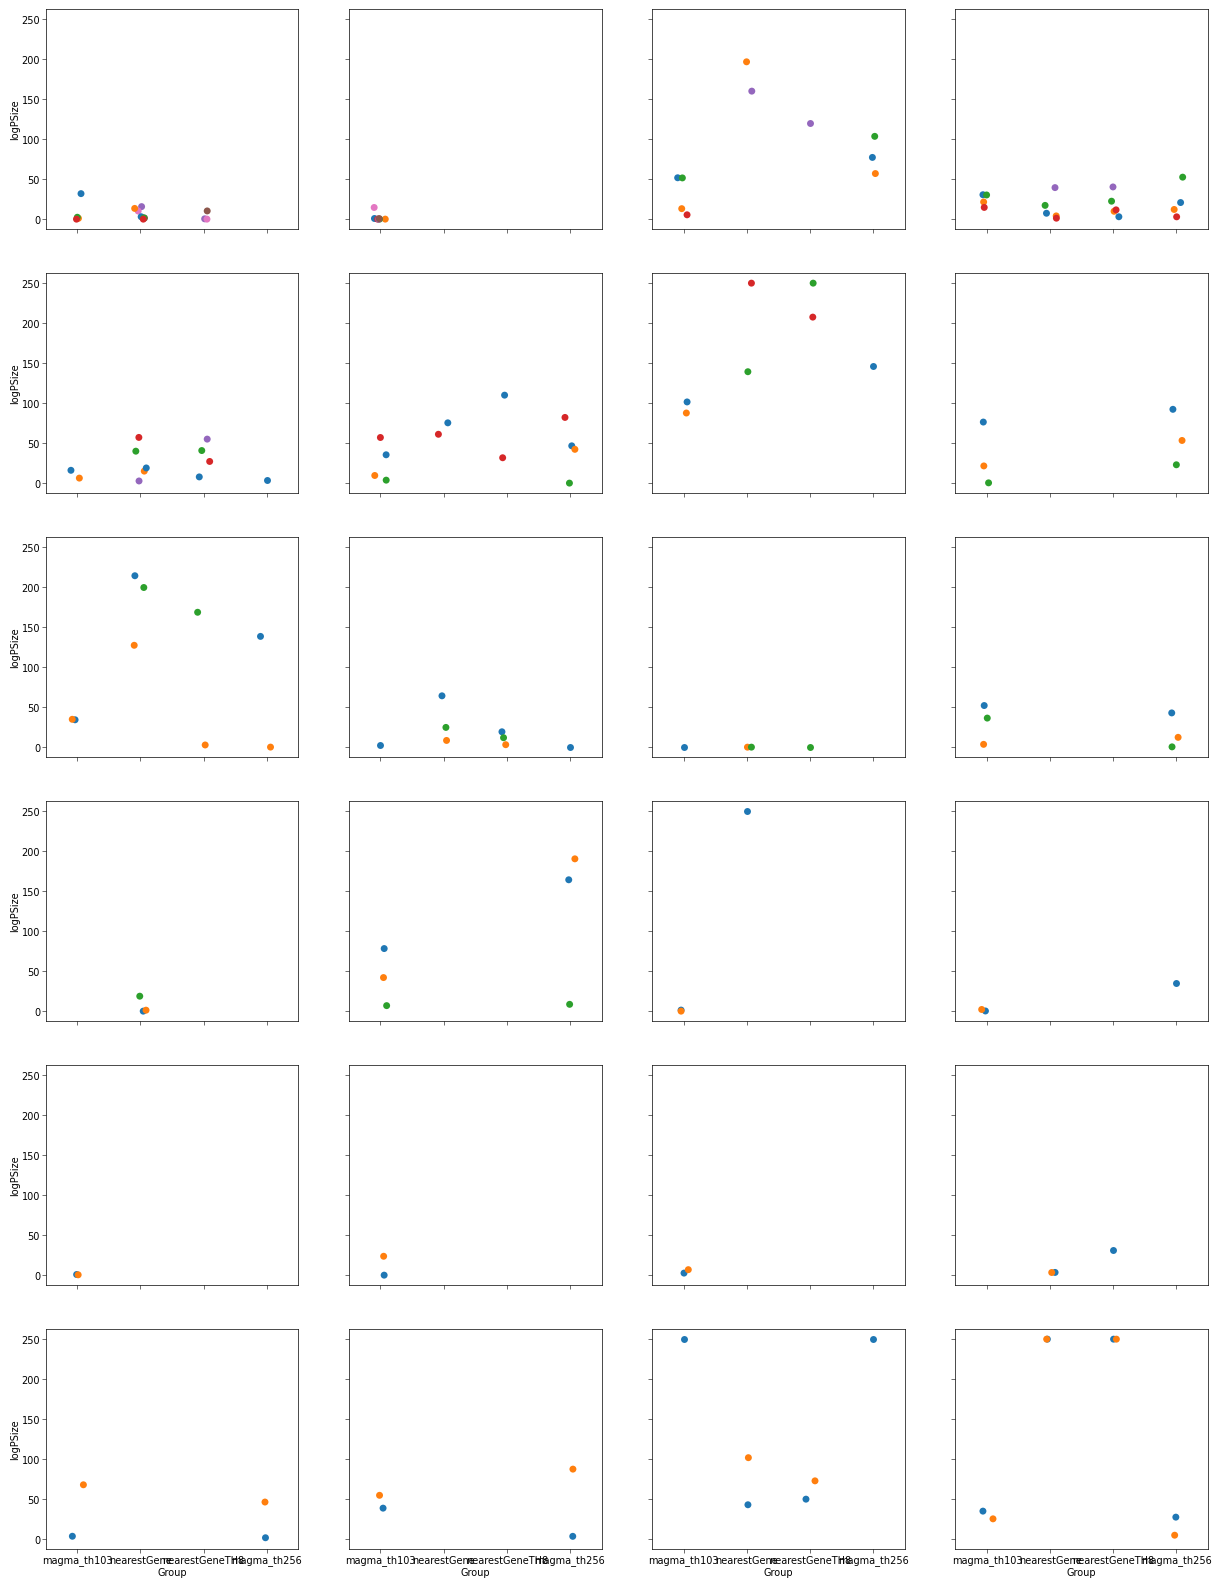

In [308]:
_, all_axs = plt.subplots(nrows=6, ncols=4, figsize=(15, 20), sharex=True, sharey=True)
axs = [x for xs in all_axs for x in xs]
for i, trait in enumerate(multi_traits):
    sns.stripplot(all_results[(all_results.Norm=='sum') &(all_results.EFO==multi_traits[i]) & (all_results.Group != 'magma_all')].reset_index(), 
                    x='Group', y='logPSize', hue='Study', ax=axs[i], legend=False)

In [341]:
all_results.head()

,TraitR,TraitC,Network,Transform,Norm,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,P_size,EFO,Study,q,Group,Threshold,Method,EFOStudy,logPNPS,logPSize
0,GCST001791_EFO_0004531,GCST001791_EFO_0004531,pcnet2_0,neglog10,max,0.291539,0.003797,0.000000e+00,476,199.826,2.701000e-101,EFO_0004531,GCST001791,True,magma_th256,High,MAGMA,EFO_0004531:GCST001791,250.000000,100.568475
0,GCST001791_EFO_0004531,GCST001791_EFO_0004531,pcnet2_0,neglog10,Base,0.290418,0.003738,9.460000e-300,473,201.207,1.619000e-101,EFO_0004531,GCST001791,True,magma_th256,High,MAGMA,EFO_0004531:GCST001791,250.000000,100.790753
0,GCST001791_EFO_0004531,GCST001791_EFO_0004531,pcnet2_0,neglog10,sum,0.291886,0.003489,5.237000e-303,477,204.009,5.152000e-93,EFO_0004531,GCST001791,True,magma_th256,High,MAGMA,EFO_0004531:GCST001791,250.000000,92.288024
0,GCST006366_EFO_0005213,GCST006366_EFO_0005213,pcnet2_0,neglog10,max,0.222286,0.000150,9.976000e-232,498,196.502,2.320000e-122,EFO_0005213,GCST006366,True,magma_th256,High,MAGMA,EFO_0005213:GCST006366,231.001044,121.634512
0,GCST006366_EFO_0005213,GCST006366_EFO_0005213,pcnet2_0,neglog10,Base,0.212583,-0.000134,5.115000e-197,488,198.591,1.692000e-113,EFO_0005213,GCST006366,True,magma_th256,High,MAGMA,EFO_0005213:GCST006366,196.291154,112.771600


In [379]:
import re
import pandas as pd

def match_p(file_name, dataframe, p_col='P_mean_NPS', print_row=False):
    """
    Matches a file name to the P_mean_NPS value in a DataFrame based on EFO, Study, Group, q, and Norm.
    
    Args:
        file_name (str): The name of the file containing EFO, Study, Group, q, and normalization information.
        dataframe (pd.DataFrame): The DataFrame containing metadata and results.
    
    Returns:
        float: The matched P_mean_NPS value or None if no match is found.
    """
    # Extract EFO and Study from the file name
    efo_match = re.search(r'EFO_\d+', file_name)
    study_match = re.search(r'GCST\d+', file_name)
    group_match = re.search(r'(magma_th256|magma_th103|magma_all|nearestGene|nearestGeneTH8)', file_name)
    q_value = 'q' in file_name  # q is True if 'q' is in the file name
    
    if not efo_match or not study_match or not group_match:
        return None  # Return None if required fields are not found in the file name
    
    efo = efo_match.group()
    study = study_match.group()
    group = group_match.group()
    
    # Determine normalization method from the file name
    if 'max' in file_name:
        norm = 'max'
    elif 'sum' in file_name:
        norm = 'sum'
    elif 'None' in file_name:
        norm = 'None'
    elif not q_value:  # q is True
        norm = 'Binary'
    else:
        norm = 'Base'
    
    # Filter the DataFrame based on EFO, Study, Group, q, and Norm
    matched_row = dataframe[
        (dataframe['EFO'] == efo) &
        (dataframe['Study'] == study) &
        (dataframe['Group'] == group) &
        (dataframe['q'] == q_value) &
        (dataframe['Norm'] == norm)
    ]
    if print_row:
        print(matched_row)
    # Return the P_mean_NPS value if a match is found, otherwise return None
    return matched_row[p_col].values[0] if not matched_row.empty else None



In [380]:
x = match_p(mgFiles[7], all_results, p_col='P_size', print_row=True)

                   TraitR                  TraitC   Network Transform    Norm  \
0  GCST009407_EFO_0006525  GCST009407_EFO_0006525  pcnet2_0  neglog10  Binary   

   Mean_NPS  Null_mean_NPS    P_mean_NPS  Size  Null_Size  P_size  \
0  0.075923      -0.000421  1.547000e-22   236    256.829  0.9334   

           EFO       Study      q        Group Threshold Method  \
0  EFO_0006525  GCST009407  False  magma_th256      High  MAGMA   

                 EFOStudy   logPNPS  logPSize  
0  EFO_0006525:GCST009407  21.81051  0.029932  


In [349]:
mgFiles[2]

'/cellar/users/snwright/Data/RareCommon/outputs/netcoloc/magma/magma_th256_GCST90179151_EFO_0006525_z_RV_neglog10.tsv'

### Trait repeat set up

In [400]:
sum_counts = all_results[all_results.Group.isin(['magma_th103', 'nearestGene']) & all_results.Norm.isin(['sum'])].EFOStudy.value_counts()
sum_patterns = all_results[all_results.EFOStudy.isin(sum_counts[sum_counts > 1].index.tolist())].TraitR.unique()
with open('/cellar/users/snwright/Data/RareCommon/inputs/magma/magma2/sum_patterns.txt', 'w') as f:
    f.write('\n'.join(sum_patterns)+'\n')
with open('/cellar/users/snwright/Data/RareCommon/inputs/testing/testing2/sum_patterns.txt', 'w') as f:
    f.write('\n'.join(sum_patterns)+'\n')

In [399]:
base_counts = all_results[all_results.Group.isin(['magma_th103', 'nearestGene']) & all_results.Norm.isin(['Base'])].EFOStudy.value_counts()
base_patterns = all_results[all_results.EFOStudy.isin(base_counts[base_counts > 1].index.tolist())].TraitR.unique()
with open('/cellar/users/snwright/Data/RareCommon/inputs/magma/magma2/base_patterns.txt', 'w') as f:
    f.write('\n'.join(base_patterns)+'\n')
with open('/cellar/users/snwright/Data/RareCommon/inputs/testing/testing2/base_patterns.txt', 'w') as f:
    f.write('\n'.join(base_patterns)+'\n')

In [397]:
binary_counts = all_results[all_results.Group.isin(['magma_th103', 'nearestGene']) & all_results.Norm.isin(['Binary'])].EFOStudy.value_counts()
binary_patterns = all_results[all_results.EFOStudy.isin(binary_counts[binary_counts > 1].index.tolist())].TraitR.unique()
with open('/cellar/users/snwright/Data/RareCommon/inputs/testing/testing2/binary_patterns.txt', 'w') as f:
    f.write('\n'.join(binary_patterns)+'\n')
with open('/cellar/users/snwright/Data/RareCommon/inputs/magma/magma2/binary_patterns.txt', 'w') as f:
    f.write('\n'.join(binary_patterns)+'\n')

## NPS Distributions

In [333]:
ngFiles = glob.glob(ngout+'/*'+multi_traits[5]+'*')
mgFiles = [x for x in glob.glob(magmaout+'/*'+multi_traits[5]+'*') if ('magma_th' in x)]
mgFiles = [x for x in mgFiles if ('max' not in x) and ('None' not in x) and ('netcoloc_' not in x)]

In [372]:
mgFiles[7]

'/cellar/users/snwright/Data/RareCommon/outputs/netcoloc/magma/magma_th256_GCST009407_EFO_0006525_z_RV_neglog10.tsv'

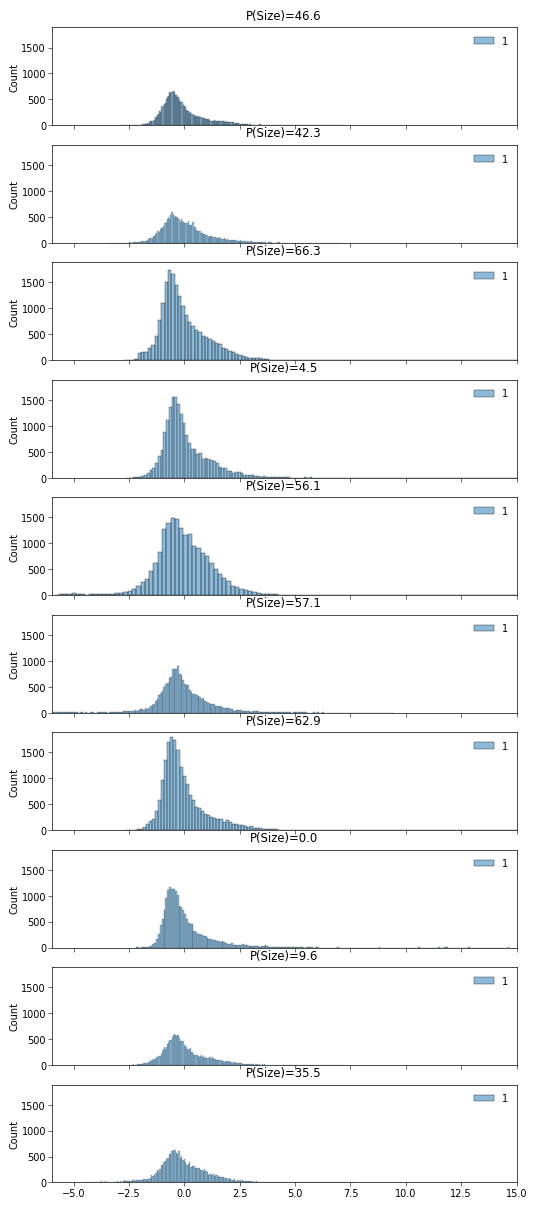

In [371]:
_, axs = plt.subplots(nrows=10, ncols=1, figsize=(6, 15), sharex=True, sharey=True)
for i, f in enumerate(mgFiles[0:10]):
    z_scores = pd.read_csv(f, sep='\t', header=None, index_col=0)
    sns.histplot(z_scores, bins=200, ax=axs[i])
    axs[i].set_xlim((-6, 15))
    axs[i].set_title(f'P(Size)={-1 * np.log10(match_p(f, all_results, p_col="P_size")+1e-250):.1f}')

## Overlap methods

In [88]:
### Load data
bin_files = glob.glob('/cellar/users/snwright/Data/RareCommon/outputs/netcoloc/overlap_bin/qnetcoloc*')
remove_files = glob.glob('/cellar/users/snwright/Data/RareCommon/outputs/netcoloc/overlap_remove/qnetcoloc*')

In [134]:
def extract_metadata(fullfile, group):
    filename = os.path.basename(fullfile)
    trait1 = filename.split(group+'_')[1]
    norm = filename.split('_')[-1].split('.txt')[0]
    try:
        overlap = float(filename.split('__q')[0].split('_')[-1])
    except ValueError:
        overlap=0
    trait2 = filename.split(group+'_')[2].split('_0')[0]
    return norm, overlap

In [138]:
bin_results  = []
for f in bin_files:
    df = pd.read_csv(f, sep='\t', header=None, names=['TraitR', 'TraitC', 'Network','Transform', 'Norm', 'Mean_NPS', 'Null_mean_NPS', 'P_mean_NPS', 'Size', 'Null_Size', 'P_size' ])
    norm, overlap = extract_metadata(f, 'nearestGene')
    df['Norm'] = norm
    df['Overlap'] = overlap
    bin_results.append(df)
bin_df = pd.concat(bin_results)

In [150]:
bin_df['TraitR'] = bin_df['TraitR'].apply(lambda x: x.split('_0.')[0])
bin_df['TraitC'] = bin_df['TraitC'].apply(lambda x: x.split('_0.')[0])
bin_df['log2SizeOE'] = np.log2(bin_df.Size / bin_df.Null_Size)
bin_df['OverlapMethod'] = 'Bin'

In [149]:
bin_df.Overlap.value_counts()

Overlap
0.00    46
0.90    44
0.75    44
0.50    43
0.25    37
0.10    19
Name: count, dtype: int64

In [151]:
remove_results  = []
for f in remove_files:
    df = pd.read_csv(f, sep='\t', header=None, names=['TraitR', 'TraitC', 'Network','Transform', 'Norm', 'Mean_NPS', 'Null_mean_NPS', 'P_mean_NPS', 'Size', 'Null_Size', 'P_size' ])
    norm, overlap = extract_metadata(f, 'nearestGene')
    df['Norm'] = norm
    df['Overlap'] = overlap
    remove_results.append(df)
remove_df = pd.concat(remove_results)

In [152]:
remove_df['TraitR'] = remove_df['TraitR'].apply(lambda x: x.split('_0.')[0])
remove_df['TraitC'] = remove_df['TraitC'].apply(lambda x: x.split('_0.')[0])
remove_df['log2SizeOE'] = np.log2(remove_df.Size / remove_df.Null_Size)
remove_df['OverlapMethod'] = 'Remove'

In [153]:
remove_df.Overlap.value_counts()

Overlap
0.00    46
0.75    44
0.90    44
0.50    43
0.25    37
0.10    19
Name: count, dtype: int64

In [162]:
all_overlap = pd.concat([bin_df, remove_df])
all_overlap['logp_nps'] = -1*np.log10(all_overlap.P_mean_NPS + 1e-250)
all_overlap['logp_size'] = -1*np.log10(all_overlap.P_size + 1e-250)

<Axes: xlabel='Overlap', ylabel='log2SizeOE'>

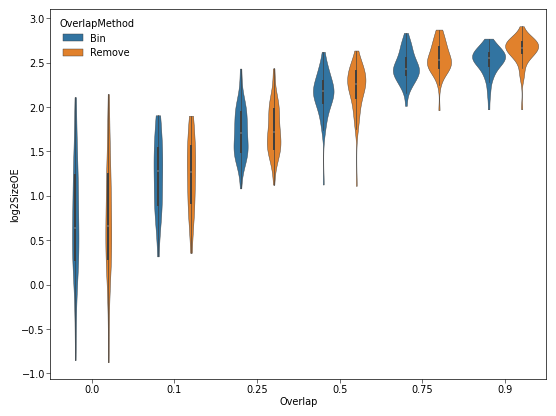

In [164]:
sns.violinplot(all_overlap, x='Overlap', y='log2SizeOE', hue='OverlapMethod', cut=0)

<Axes: xlabel='Overlap', ylabel='Mean_NPS'>

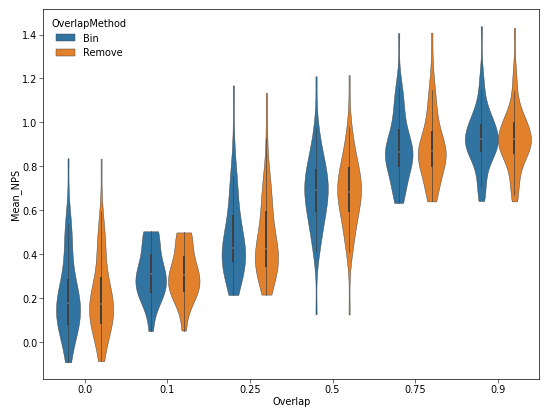

In [165]:
sns.violinplot(all_overlap, x='Overlap', y='Mean_NPS', hue='OverlapMethod', cut=0)

<Axes: xlabel='Overlap', ylabel='logp_size'>

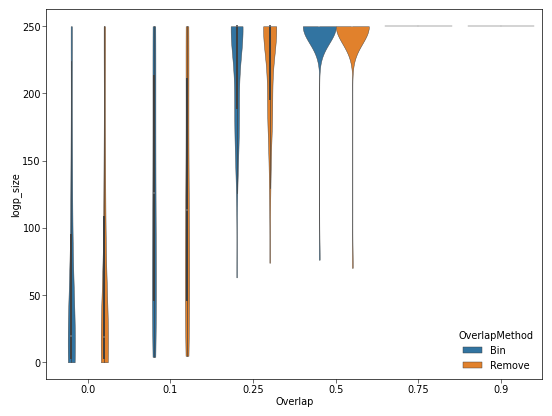

In [166]:
sns.violinplot(all_overlap, x='Overlap', y='logp_size', hue='OverlapMethod', cut=0)

<Axes: xlabel='Overlap', ylabel='logp_nps'>

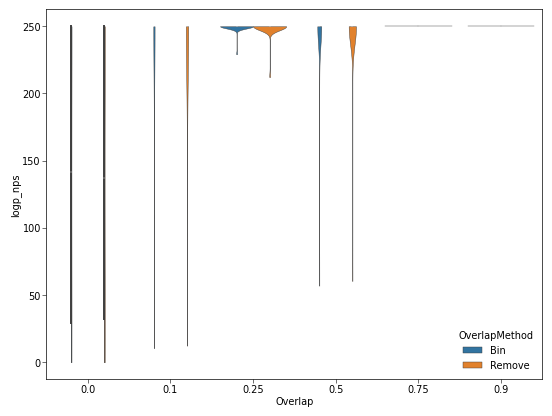

In [167]:
sns.violinplot(all_overlap, x='Overlap', y='logp_nps', hue='OverlapMethod', cut=0)

In [170]:
all_overlap[all_overlap.logp_size==250]

,TraitR,TraitC,Network,Transform,Norm,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,P_size,Overlap,log2SizeOE,OverlapMethod,logp_nps,logp_size
0,nearestGene_EFO_0004343_GCST008996,nearestGene_EFO_0004343_GCST008996,pcnet2_0,neglog10,sum,1.205452,0.035082,0.0,1434,326.039,0.0,0.90,2.136929,Bin,250.0,250.0
0,nearestGene_EFO_0006332_GCST90100525,nearestGene_EFO_0006332_GCST90100525,pcnet2_0,neglog10,sum,1.437652,0.064115,0.0,1292,196.906,0.0,0.90,2.714027,Bin,250.0,250.0
0,nearestGene_EFO_0021898_GCST90269581,nearestGene_EFO_0021898_GCST90269581,pcnet2_0,neglog10,sum,0.698408,0.000959,0.0,1096,183.253,0.0,0.75,2.580339,Bin,250.0,250.0
0,nearestGene_EFO_0010225_GCST90060151,nearestGene_EFO_0010225_GCST90060151,pcnet2_0,neglog10,sum,1.027126,0.015967,0.0,1259,217.729,0.0,0.75,2.531673,Bin,250.0,250.0
0,nearestGene_EFO_0010821_GCST90016673,nearestGene_EFO_0010821_GCST90016673,pcnet2_0,neglog10,sum,0.573251,-0.000947,0.0,704,174.895,0.0,0.25,2.009086,Bin,250.0,250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,nearestGene_EFO_0008036_GCST90094959,nearestGene_EFO_0008036_GCST90094959,pcnet2_0,neglog10,sum,0.719382,-0.000153,0.0,960,291.623,0.0,0.25,1.718930,Remove,250.0,250.0
0,nearestGene_EFO_0010225_GCST90060151,nearestGene_EFO_0010225_GCST90060151,pcnet2_0,neglog10,sum,1.027950,0.015622,0.0,1255,216.213,0.0,0.90,2.537162,Remove,250.0,250.0
0,nearestGene_EFO_0004343_GCST008997,nearestGene_EFO_0004343_GCST008997,pcnet2_0,neglog10,sum,0.636258,0.001374,0.0,785,185.104,0.0,0.25,2.084357,Remove,250.0,250.0
0,nearestGene_EFO_0004343_GCST008997,nearestGene_EFO_0004343_GCST008997,pcnet2_0,neglog10,sum,0.747882,0.003441,0.0,915,174.937,0.0,0.50,2.386936,Remove,250.0,250.0


# Development

## Data import fuctions

In [28]:
def load_results(trait_file, datadir, resdir, result_pref='pilot_netcoloc_results_', result_suff=''):
    with open(os.path.join(datadir, trait_file), 'r') as f:
        b_traits = [x.strip() for x in f.readlines()]
    b_list = []
    for t in b_traits:
        try:
            b_list.append(pd.read_csv(os.path.join(resdir, f'{result_pref}{t}_{t}{result_suff}.txt'), sep='\t', header=None))
        except FileNotFoundError:
            print(f'Trait not found: {t}')

    b_results = pd.concat(b_list)
    b_results.columns = ['TraitR', 'TraitC', 'Network','Mean_NPS', 'Null_mean_NPS', 'P_mean_NPS', 'Size', 'Null_Size', 'P_size' ]
    b_results['Trait'] = b_results.TraitR.apply(lambda x: '_'.join(x.split('_')[1:3]))
    b_results['Study'] = b_results.TraitR.apply(lambda x: x.split('_')[-1])
    return b_results

def add_study_info(results_df):
    pass

def add_geneset_info(results_df):
    pass

## Data Analysis Functions

In [ ]:
def compare_methods(res_df_list):
    pass

def compare_trait_repeats(res_df):
    pass

# Nearest Gene

## Binary